<img src="../data/unjust.jpg">
# **Chapter 3 | word2vec**
## **1 데이터 전처리**

In [1]:
# ! apt-get update
# ! apt-get install g++ openjdk-8-jdk 
# ! pip3  install  nltk konlpy matplotlib gensim 

# ! apt-get install fonts-nanum-eco
# ! apt-get install fontconfig
# ! fc-cache -fv
# ! cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
# ! rm -rf /content/.cache/matplotlib/*

In [2]:
speech_text = "https://raw.githubusercontent.com/YongBeomKim/nltk_tutorial/master/data/pyongyang_fin.txt"
script_text = "https://raw.githubusercontent.com/YongBeomKim/nltk_tutorial/master/data/movie_memories_of_murder_2003.txt"
# font_file = "/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/NanumGothicCoding.ttf"
font_file = "./D2Coding.ttf"

In [3]:
import matplotlib as mpl        
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_name   = fm.FontProperties(fname=font_file, size=10).get_name()
plt.rc('font', family=font_name)
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
# 텍스트를 줄단위로 끊어서 불러온뒤
# Token 단위로, 한글명사들을 추출한다
def txtnoun(sentences , skip=False, tags=['Noun'], stem=True, set_tokens=False):

    r"""
    살인의 추억 대본의 텍스트 전처리 작업을 진행합니다
    :param sentences: 단일한 Text String 데이터를 입력합니다
    :param skip: 분류된 Token 중 사용자가 원하는 형태로 변환된 내용을 출력
    :param tags: konlpy 로 분류된 품사중 추출하고자 하는 품사를 정의합니다
    :param stem: stemming 작업여부를 정의합니다.
    :param set_tokens: return 결과를 token list 객체로 출력할지를 정의합니다
    :return: set_tokens 내용에 따라 List, String 타입으로 출력합니다
    """
    
    import re
    from konlpy.tag import Okt
    twitter = Okt()
    result  = []
    sentences = sentences.replace('\n', '\n|')
    sentences = sentences.split('|')
    for content in sentences:
        texts      = content.replace('\n', '') # 해당줄의 줄바꿈 내용 제거
        tokenizer  = re.compile(r'[^ ㄱ-힣]+')  # 한글과 띄어쓰기를 제외한 모든 글자를 선택
        token_data = tokenizer.sub('', texts)  # 한글과 띄어쓰기를 제외한 모든 부분을 제거
        token_data = token_data.split(' ')
        sentence   = []

        for token in token_data:
            # skip 대상이 없을 떄
            if skip == False:
                chk_tok = twitter.pos(token, stem=stem)
                chk_tok = [temp[0]  for temp in chk_tok   if temp[1] in tags]
                ckeck   = "".join(chk_tok)
                if len(ckeck) > 1:
                    sentence.append(ckeck)

            # skip 내용이 있을 때
            else:
                if token.strip() in skip.keys():
                    result.append(skip[token.strip()])
                else:
                    chk_tok = twitter.pos(token, stem=stem)
                    chk_tok = [temp[0] for temp in chk_tok if temp[1] in tags]
                    ckeck   = "".join(chk_tok)

                    # 전처리가 끝난 결과가 skip에 해당여부 판단
                    if ckeck.strip() in skip.keys():
                        result.append(skip[ckeck.strip()])
                    elif len(ckeck) > 1:
                        sentence.append(ckeck)

        # 단락별 작업이 끝난 뒤 '\n'를 덧붙여서 작업을 종료
        temp = "".join(sentence)
        if len(temp) > 1:
            sentence = " ".join(sentence)
            sentence += "\n"
            result.append(sentence)

    if set_tokens == True:
        from nltk.tokenize import word_tokenize
        set_token = word_tokenize(" ".join(result))
        return list(set(set_token))

    else:
        return " ".join(result)

In [5]:
skips = {'두만':'박두만', '태윤':'서태윤', '용구':'조용구', '귀옥':'권귀옥', 
         '희봉':'구희봉', '동철':'신동철', '광호':'백광호', '병순':'조병순', 
         '해일':'박해일', '광호의':'백광호', '백광호의':'백광호'}

In [6]:
import requests
sentences = requests.get(script_text).text
sentences[:300]

'박두만\n서태윤\n조용구\n권귀옥\n구희봉\n신동철\n백광호20대 초반. 정박아\n조병순30대 후반. 변태성향\n박해일20대 초반. 공장 노동자. ‘유력한 용의자’.\n선본 남자, 동네 양아치들... 등등\n30대 초반의 전직 간호조무사, 마을 ‘야매주사’ 여인.\n안송여중 1학년 학생\n소현의 단짝 친구\n박보희, 이향숙, 독고현순, 박명자, 안미선.\n화면 가득 한 남자 아이의 얼굴이 보여진다.\n쏟아지는 햇살 아래, 맑은 눈빛의 아이는 카메라 정면을 응시하고 있다.\n아이는 코스모스 위에 앉아있는 잠자리를 향해 살며시 손을 뻗는다.\n휙~ 잠자리가 날아가 '

In [7]:
sentences   = txtnoun(sentences, skip=skips, tags=['Noun'])
script_file = 'script.txt'
with open(script_file, 'w', encoding='utf-8') as file:
    file.write(sentences)

In [8]:
%%time
from gensim.models import word2vec
data  = word2vec.LineSentence(script_file)
model = word2vec.Word2Vec(data, size=30, window=2, min_count=10, 
                          hs=1, workers=4, iter=100, sg=1)
model_file = "script.model"
model.save(model_file)

CPU times: user 1.53 s, sys: 281 ms, total: 1.81 s
Wall time: 1.54 s


<br/>
## **2 Word2Vec 모델의 활용**
모델을 활용하여 유력한 범인을 찾아보자!!

In [9]:
# 저장된 학습모델파일 불러오기
from gensim.models import word2vec
model_file = "script.model"
model = word2vec.Word2Vec.load(model_file)
len(model.wv.vocab.keys())

151

In [10]:
model.wv.vocab.keys()

dict_keys(['박두만', '서태윤', '조용구', '권귀옥', '구희봉', '백광호', '박해일', '용의자', '남자', '동네', '소현', '이향숙', '박명자', '화면', '가득', '아이', '얼굴', '아래', '눈빛', '카메라', '고개', '멀리', '점점', '소리', '모습', '머리', '인상', '형사', '박두', '여자', '시체', '후레쉬', '순간', '위로', '거기', '뭔가', '주위', '브래지어', '너머', '순경', '바람', '시작', '표정', '마주', '서로', '시선', '보고', '음악', '취조실', '사무실', '계속', '사진', '바로', '부분', '사람', '갑자기', '분위기', '얘기', '저녁', '어디', '다시', '아저씨', '진짜', '정말', '새끼', '문득', '저기', '한번', '구석', '피해자', '시점', '책상', '주변', '사건', '현장', '여기', '지금', '간다', '참깨밭', '발자국', '하나', '발견', '근처', '반장', '듯이', '잔뜩', '다리', '스타킹', '설영', '자기', '가방', '조그만', '그냥', '그게', '그거', '잠시', '목소리', '가운데', '팬티', '임마', '끄덕', '그대로', '똑바로', '잠깐', '모두', '다른', '경찰', '코피', '휴지', '누군가', '운동화', '라디오', '권기옥', '자리', '장님', '우리', '생각', '버럭', '아무', '기억', '서서히', '서류', '훈련', '불빛', '의경', '자신', '당신', '전경', '범인', '이건', '신문', '방송', '조심스레', '빗줄기', '빗소리', '어둠속', '우산', '그림자', '빗물', '학교', '변소', '사이', '괴남자', '인부', '조병순', '언덕', '언덕집', '조각', '기차', '유전자', '총구'])

<br></br>
## **4 Word2Vec 모델 내용 확인**
모델을 활용하여 유력한 범인을 찾아보자!!

In [12]:
# 범인과 관련된 내용 중 사람이름이 안나옴...
model.wv.most_similar('범인', topn=10)

/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('우리', 0.7789825797080994),
 ('얘기', 0.636168360710144),
 ('변소', 0.6269016861915588),
 ('그냥', 0.6062366366386414),
 ('거기', 0.5660851001739502),
 ('당신', 0.5464321970939636),
 ('사건', 0.5369375348091125),
 ('생각', 0.5137588381767273),
 ('학교', 0.4991469979286194),
 ('그거', 0.49561530351638794)]

In [13]:
# 현장과 가장 가깝게 등장한 인물이 1명 등장
model.wv.most_similar('현장', topn=10)

[('사진', 0.695731520652771),
 ('사건', 0.6911038160324097),
 ('이향숙', 0.6744006872177124),
 ('용의자', 0.6522321105003357),
 ('참깨밭', 0.6322036385536194),
 ('박명자', 0.6086643934249878),
 ('빗물', 0.5806044936180115),
 ('시점', 0.5740631818771362),
 ('자신', 0.5735913515090942),
 ('얼굴', 0.5522934198379517)]

In [14]:
# 현장 과 백광호 와 밀접한 증거들 중에 방해가 되는 내용을 찾는다
model.wv.most_similar(['현장','이향숙'], topn=10)

[('참깨밭', 0.7479431629180908),
 ('사진', 0.6769347190856934),
 ('근처', 0.6654631495475769),
 ('사건', 0.6539033055305481),
 ('박명자', 0.6387777924537659),
 ('발자국', 0.620755136013031),
 ('용의자', 0.5929118990898132),
 ('의경', 0.587780773639679),
 ('발견', 0.5736393928527832),
 ('위로', 0.5719764828681946)]

In [15]:
# 현장 과 백광호 와 밀접한 증거들 중에 방해가 되는 내용을 찾는다
model.wv.most_similar(['현장', '백광호'], topn=10)

[('얼굴', 0.7751262784004211),
 ('사진', 0.7635270953178406),
 ('용의자', 0.7165144681930542),
 ('이향숙', 0.656727135181427),
 ('참깨밭', 0.6377885937690735),
 ('사건', 0.6350268125534058),
 ('듯이', 0.5934072136878967),
 ('시점', 0.5894190073013306),
 ('발자국', 0.5873692631721497),
 ('조용구', 0.5837452411651611)]

In [16]:
# 현장 과 백광호 와 밀접한 증거들 중에 '참깨밭' 이 계속 방해가 됨
# 참깨밭에 백광호가 밀접하게 연결되어 있어서 이를 제외한 분석이 필요
model.wv.most_similar(['현장','백광호'], negative=['참깨밭'], topn=15)

[('얼굴', 0.7256931066513062),
 ('똑바로', 0.6719790101051331),
 ('용의자', 0.669197142124176),
 ('사진', 0.624947190284729),
 ('아래', 0.6001161932945251),
 ('빗물', 0.5979070663452148),
 ('조용구', 0.5675495266914368),
 ('그대로', 0.5590326189994812),
 ('가득', 0.5529680848121643),
 ('눈빛', 0.5487679243087769),
 ('시점', 0.5419363975524902),
 ('구희봉', 0.515805184841156),
 ('너머', 0.4866495430469513),
 ('기차', 0.482377290725708),
 ('보고', 0.4766646921634674)]

In [18]:
# 현장 과 백광호 와 밀접한 증거들 중에 '참깨밭' 이 계속 방해가 됨
# 참깨밭에 백광호와 이향숙을 제외한 분석이 필요
model.wv.most_similar(['현장','백광호'], negative=['참깨밭','이향숙'], topn=20)

[('똑바로', 0.5776932239532471),
 ('아래', 0.5207585096359253),
 ('눈빛', 0.43736010789871216),
 ('시작', 0.4349358081817627),
 ('그대로', 0.4337351322174072),
 ('보고', 0.41873276233673096),
 ('총구', 0.4122723937034607),
 ('다리', 0.3984438478946686),
 ('서서히', 0.381930947303772),
 ('너머', 0.37939023971557617),
 ('가득', 0.3643595278263092),
 ('빗물', 0.3619527518749237),
 ('서태윤', 0.33352482318878174),
 ('기차', 0.32614970207214355),
 ('조용구', 0.32240116596221924),
 ('구희봉', 0.3207661509513855),
 ('얼굴', 0.31795206665992737),
 ('용의자', 0.30031338334083557),
 ('박해일', 0.2851952910423279),
 ('언덕', 0.2802730202674866)]

<br></br>
## **5 Visulaization**
gensim

In [19]:
vocab = list(model.wv.vocab)
X     = model[vocab]

/home/markbaum/Python/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [20]:
from sklearn.manifold import TSNE
tsne   = TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X)

In [21]:
import pandas as pd
df = pd.DataFrame(X_tsne, 
                  index   = vocab, 
                  columns = ['x', 'y'])
df.head()

,x,y
박두만,-0.738805,-0.821626
서태윤,-0.241035,-1.121973
조용구,-1.484546,-1.478399
권귀옥,-1.287762,0.297219
구희봉,-1.849630,-2.634443


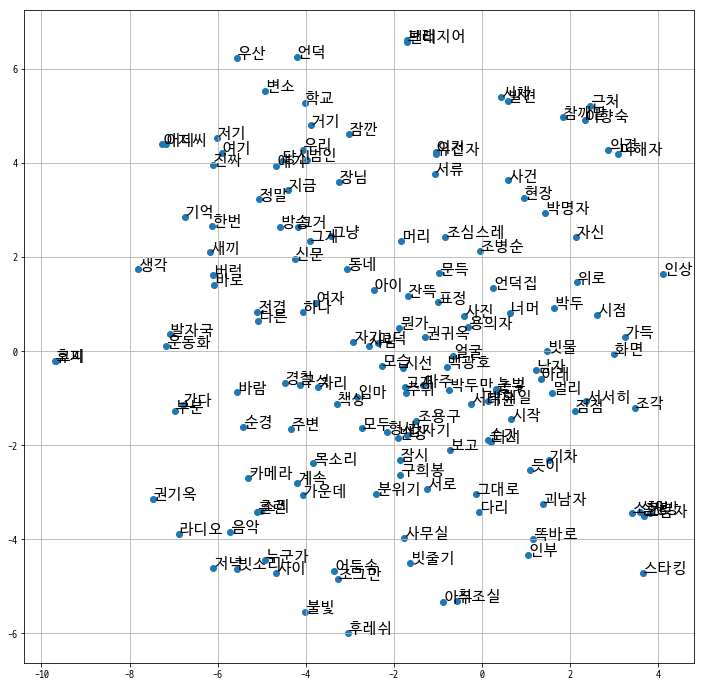

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
fig  = plt.figure(figsize=(12,12))
ax   = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=15)
plt.grid(True)

<br></br>
## **6 결과의 해석 및 활용**
1. 유사관계, 반대관계로 **출력된 모든 Token들이 가치가 있지는 않다**
1. **min_count, Vector 갯수** 2가지 조건만 사용하여 모델을 생성한다
1. Word2Vec 도 **문서를 분석하는 도구**에 불과 (절대적 **가치를 창출하는 기법** 으로 오해 X)
1. 해당 분야의 **잘 정리된 Document로 학습한 Word2Vec 모델** 에서 **유의미 한 token 들의 관계** 를 Template으로 잘 정리
1. 분석대상 문서를 **유사한 조건으로 word2vec 모델** 을 만들고, **앞에서 정리된 Template와** 비교하여 결과
다듬기
1. 시나리오의 분석 경우
    1. 결과물 중 인물의 Token 만 활용하여 분석
    1. 결과물 중 증거물의 Token 만 활용하여 분석
    1. 결과물 중 장소의 Token 만 활용하여 분석

In [ ]:
# model 에 등장하는 인물들
charator = ["박두만", "서태윤", "조용구", "권귀옥", "구희봉", "신동철", "백광호",
            "조병순", "박해일", "박보희", "이향숙", "독고현순", "박명자", "안미선", 
            "반장", "소현", "범인", "형사", '괴남자', '순경','피해자', '권기옥','용의자']

In [ ]:
# model 에 등장하는 장소명 들
area = ['현장', '사무실', '취조실', '변소', '참깨밭', '빗줄기', '어둠속', '언덕집']

In [ ]:
# model 에 등장하는 Item 들
items = ['브래지어', '팬티', '우산', '운동화', '스타킹', '목소리', '불빛', '음악', '후레쉬', 
         '카메라', '라디오', '방송', '유전자', '가방', '코피', '휴지', '신문', '총구']